# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [11]:
#посмотрим на пример

print(dataset['train'][0])
print(train_dataset[0])

#как можно заметить по слову "Reuters" которое повторяется дважды подряд и индексу 1900, которое так же встречается дважды подряд

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
{'text': [2263, 1662, 466, 167, 1399, 1002, 5901, 1641, 2927, 1900, 1900, 1399, 1662, 9324, 1399, 2634, 1399, 3865, 4856, 8042, 7392, 11139], 'label': 2}


## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [12]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

## Начнем

### Для начала напишим код для тренеровки и графиков с лоссами и акураси

In [13]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']

In [14]:
def draw_loss(losses_type):
    if len(losses_type) > len(colors):
        raise RuntimeError('len(losses_type) > len(colors)')

    for (name, values), color in zip(losses_type.items(), colors[:len(losses_type)]):
        plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

def draw_acc(losses_type, acc_type):
    if len(losses_type) > len(colors):
        raise RuntimeError('len(losses_type) > len(colors)')

    for (name, values), color in zip(losses_type.items(),colors[:len(losses_type)]):
        plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
        print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

def draw_stats(losses_type, acc_type):
    draw_loss(losses_type)
    draw_acc(losses_type, acc_type)

In [15]:
def train_(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch = 5, eval_steps=None):
    if eval_steps is None:
        eval_steps = len(train_dataloader) // 2 # evaluate two timws per epo
    losses = []
    acc = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    return losses, acc

In [ ]:
def train_CharlLM(model, optimizer, criterion, train_dataloader, num_epoch = 5, eval_steps=None):
    losses_type = {}
    acc_type = {}

    for aggregation_type in ['max', 'mean']:
        print(f"Starting training for {aggregation_type}")
        losses = []
        acc = []

        model = CharLM(
            hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model.parameters())

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

### Запуск базовой модели с семинара на новом датасете

In [16]:
class MaxAggrigation(nn.Module):
    def forward(self, x):
        return x.max(dim=1)[0]

class MeanAggrigation(nn.Module):
    def forward(seld, x):
        return x.mean(dim=1)

In [17]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


        if aggregation_type == 'max':
            self.aggregation = MaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = MeanAggrigation()
        else:
            raise ValueError("Invalid aggregation_type")

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregation(output) #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

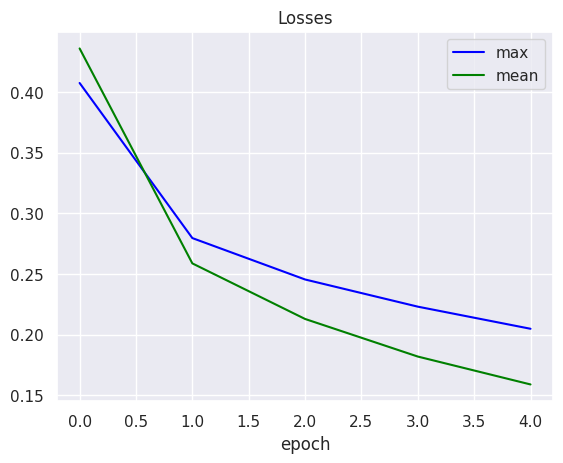

Лучшая accuracy для подхода max: 90.42
Лучшая accuracy для подхода mean: 90.82


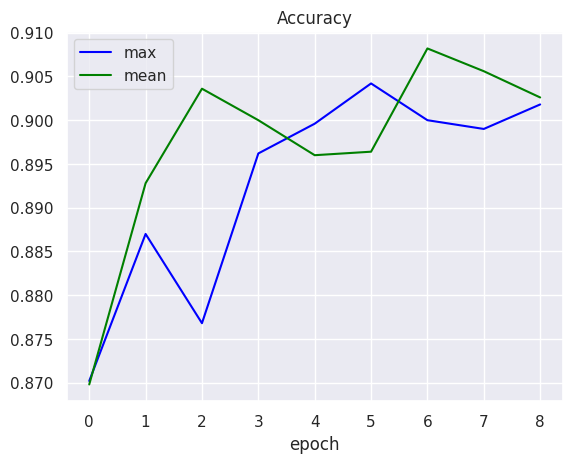

In [ ]:
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    # model, optimizer, criterion, train_dataloader, num_epoch = 5, eval_steps=None
    losses, acc = train_(model=model, optimizer=optimizer, criterion=criterion,
                        train_dataloader=train_dataloader, eval_dataloader=eval_dataloader)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

draw_stats(losses_type, acc_type)

### Эксперементы

#### LSTM

In [ ]:
class LSTM_LM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


        if aggregation_type == 'max':
            self.aggregation = MaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = MeanAggrigation()
        else:
            raise ValueError("Invalid aggregation_type")

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregation(output) #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

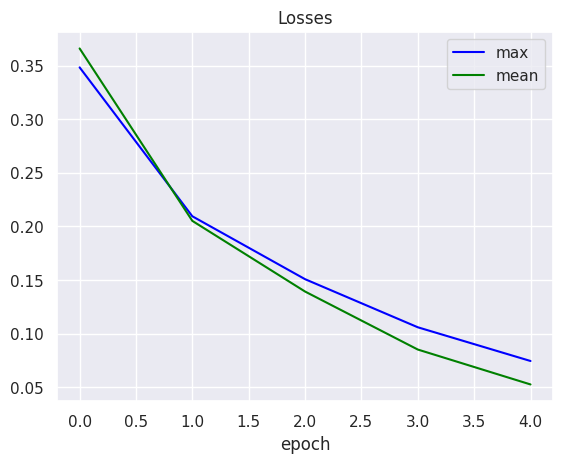

Лучшая accuracy для подхода max: 91.42
Лучшая accuracy для подхода mean: 91.76


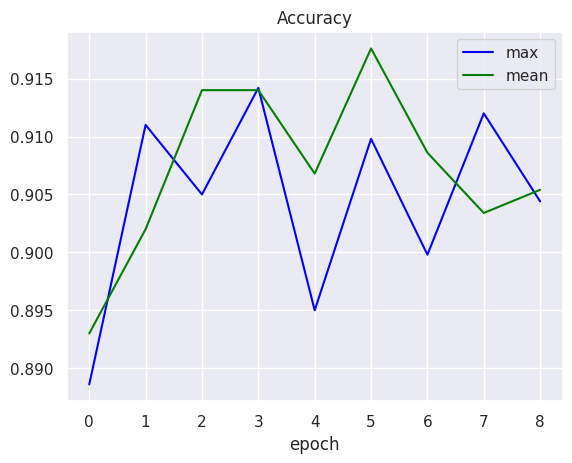

In [ ]:
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = LSTM_LM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    # model, optimizer, criterion, train_dataloader, num_epoch = 5, eval_steps=None
    losses, acc = train_(model=model, optimizer=optimizer, criterion=criterion,
                        train_dataloader=train_dataloader, eval_dataloader=eval_dataloader)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

draw_stats(losses_type, acc_type)

#### теперь GRU

In [ ]:
class GRU_LM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


        if aggregation_type == 'max':
            self.aggregation = MaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = MeanAggrigation()
        else:
            raise ValueError("Invalid aggregation_type")

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregation(output) #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

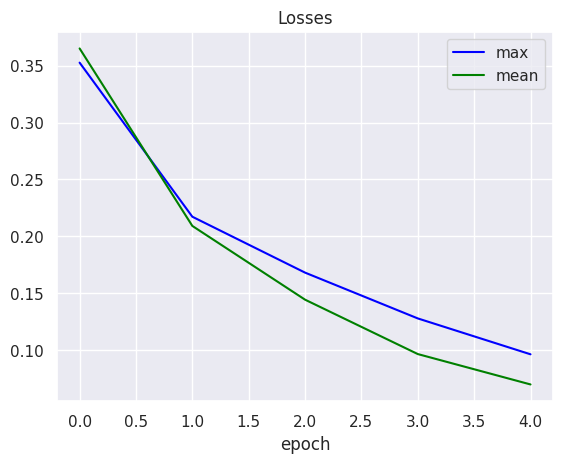

Лучшая accuracy для подхода max: 91.28
Лучшая accuracy для подхода mean: 91.12


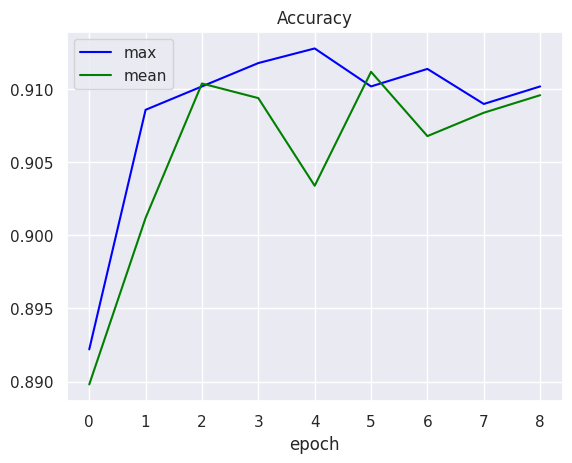

In [ ]:
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = GRU_LM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    # model, optimizer, criterion, train_dataloader, num_epoch = 5, eval_steps=None
    losses, acc = train_(model=model, optimizer=optimizer, criterion=criterion,
                        train_dataloader=train_dataloader, eval_dataloader=eval_dataloader)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

draw_stats(losses_type, acc_type)

LSTM показала лучший результат

#### Увеличим количество слоев рекурентных слоев до 2х

In [ ]:
class Char2LM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max',
        recurent_layers=2
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=recurent_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


        if aggregation_type == 'max':
            self.aggregation = MaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = MeanAggrigation()
        else:
            raise ValueError("Invalid aggregation_type")

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregation(output) #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

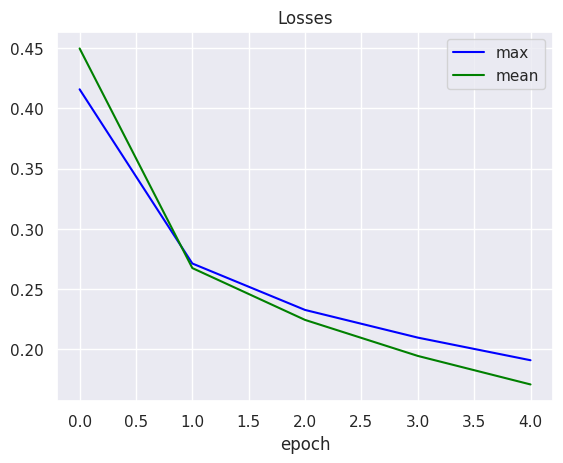

Лучшая accuracy для подхода max: 91.26
Лучшая accuracy для подхода mean: 90.78


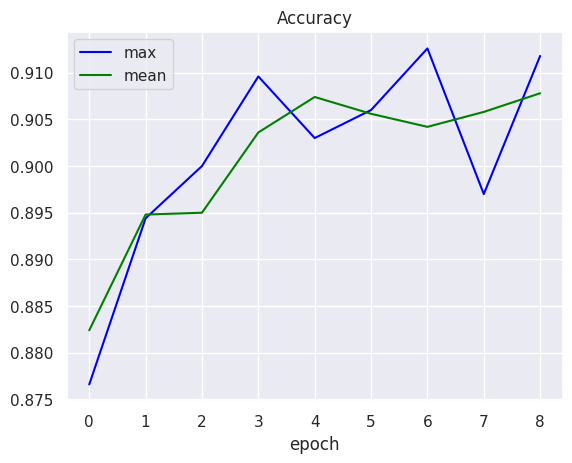

In [ ]:
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = Char2LM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    # model, optimizer, criterion, train_dataloader, num_epoch = 5, eval_steps=None
    losses, acc = train_(model=model, optimizer=optimizer, criterion=criterion,
                        train_dataloader=train_dataloader, eval_dataloader=eval_dataloader)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

draw_stats(losses_type, acc_type)

#### Теперь 4 слоя

In [ ]:
class Char4LM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max',
        recurent_layers=4
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=recurent_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


        if aggregation_type == 'max':
            self.aggregation = MaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = MeanAggrigation()
        else:
            raise ValueError("Invalid aggregation_type")

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregation(output) #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

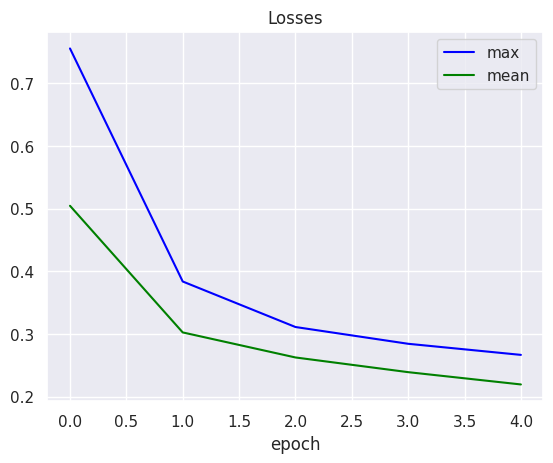

Лучшая accuracy для подхода max: 90.62
Лучшая accuracy для подхода mean: 90.28


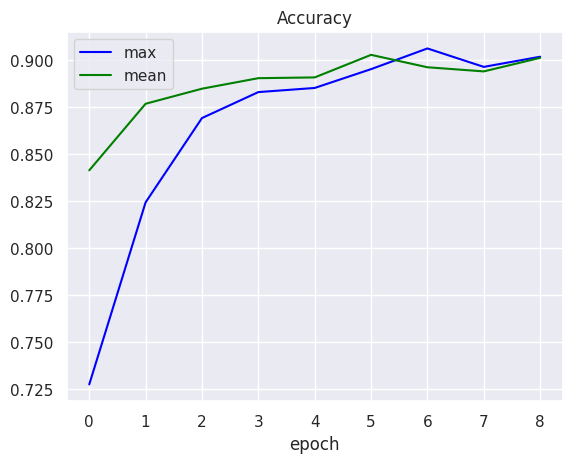

In [ ]:
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = Char4LM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())


    losses, acc = train_(model=model, optimizer=optimizer, criterion=criterion,
                        train_dataloader=train_dataloader, eval_dataloader=eval_dataloader)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

draw_stats(losses_type, acc_type)

стало немного хуже

#### конкатенируем результат агрегации и эмбеддинг с последнего токена

In [ ]:
class CatMaxAggrigation(nn.Module):
    def forward(self, x):
        return torch.cat((x.max(dim=1)[0], x[:,-1,:]), dim=1)

class CatMeanAggrigation(nn.Module):
    def forward(seld, x):
        return torch.cat((x.mean(dim=1), x[:,-1,:]), dim=1)

In [ ]:
class CatCharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        # умножаем на 2 тк приконкатенируем последний ембединг
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


        if aggregation_type == 'max':
            self.aggregation = CatMaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = CatMeanAggrigation()
        else:
            raise ValueError("Invalid aggregation_type")

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregation(output) #[batch_size, hidden_dim*2]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

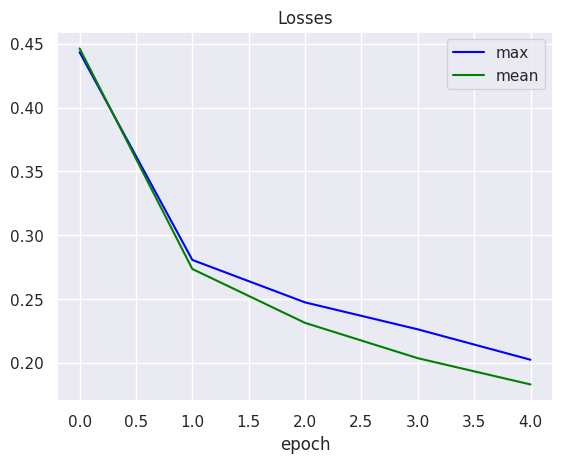

Лучшая accuracy для подхода max: 90.86
Лучшая accuracy для подхода mean: 90.78


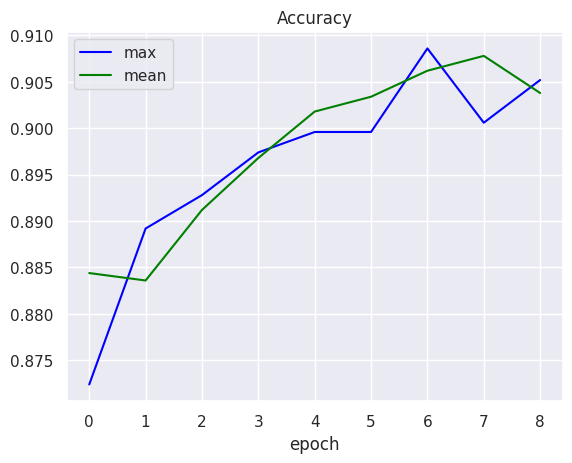

In [ ]:
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CatCharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())


    losses, acc = train_(model=model, optimizer=optimizer, criterion=criterion,
                        train_dataloader=train_dataloader, eval_dataloader=eval_dataloader)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

draw_stats(losses_type, acc_type)

это дало небольщое улучшение

#### Подбор гиперпараметров: увеличение hidden_dim

In [ ]:
class WideCharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


        if aggregation_type == 'max':
            self.aggregation = MaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = MeanAggrigation()
        else:
            raise ValueError("Invalid aggregation_type")

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregation(output) #[batch_size, hidden_dim*2]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

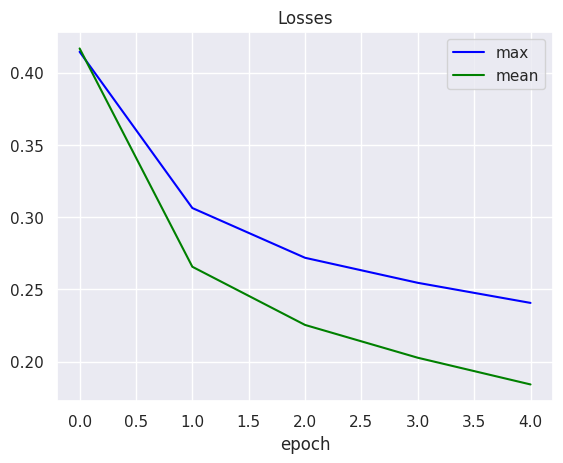

Лучшая accuracy для подхода max: 90.82
Лучшая accuracy для подхода mean: 90.72


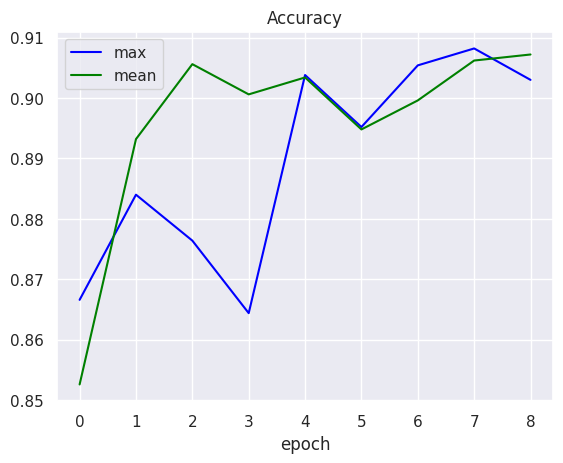

In [ ]:
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = WideCharLM(hidden_dim=256*2, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())


    losses, acc = train_(model=model, optimizer=optimizer, criterion=criterion,
                        train_dataloader=train_dataloader, eval_dataloader=eval_dataloader)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

draw_stats(losses_type, acc_type)

Теперь увеличим количество эпох

In [ ]:
class EpoCharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


        if aggregation_type == 'max':
            self.aggregation = MaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = MeanAggrigation()
        else:
            raise ValueError("Invalid aggregation_type")

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregation(output) #[batch_size, hidden_dim*2]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

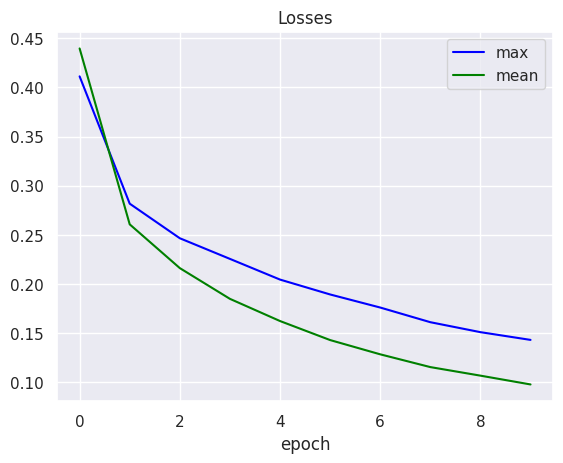

Лучшая accuracy для подхода max: 91.08
Лучшая accuracy для подхода mean: 90.94


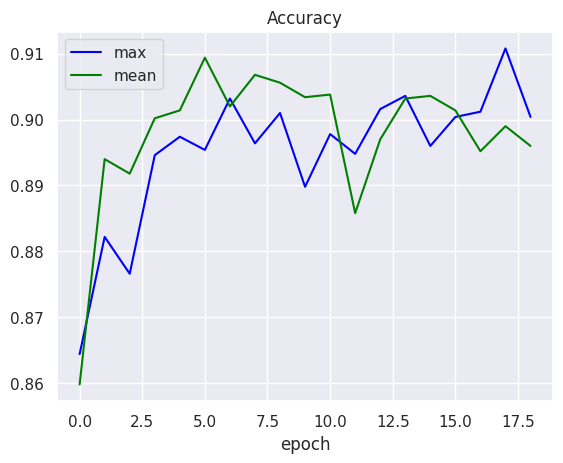

In [ ]:
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = EpoCharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())


    losses, acc = train_(model=model, optimizer=optimizer, criterion=criterion,
                        train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=10)

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

draw_stats(losses_type, acc_type)

Увеличение эпох дало результат


#### Теперь совместим:  
LSTM + wide + epo  

In [18]:
class WideEpoLSTM_LM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)


        if aggregation_type == 'max':
            self.aggregation = MaxAggrigation()
        elif aggregation_type == 'mean':
            self.aggregation = MeanAggrigation()
        else:
            raise ValueError("Invalid aggregation_type")

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregation(output) #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/3750 [00:00<?, ?it/s]

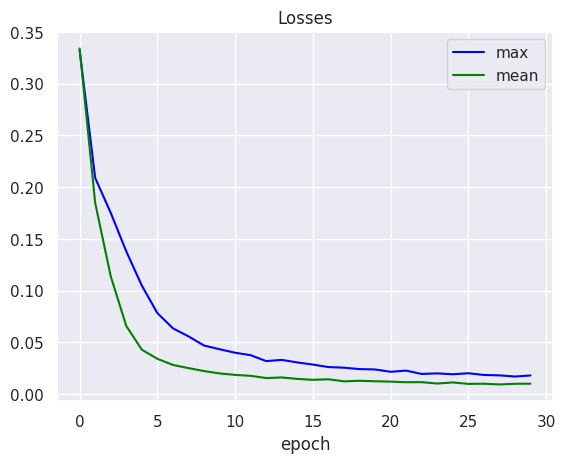

Лучшая accuracy для подхода max: 91.26
Лучшая accuracy для подхода mean: 91.62


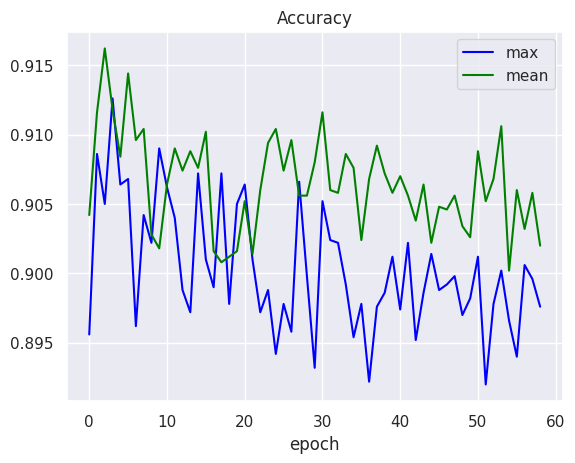

In [20]:
losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = WideEpoLSTM_LM(hidden_dim=256*2, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device) # <-- hidden_dim x2
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    # model, optimizer, criterion, train_dataloader, num_epoch = 5, eval_steps=None
    losses, acc = train_(model=model, optimizer=optimizer, criterion=criterion,
                        train_dataloader=train_dataloader, eval_dataloader=eval_dataloader, num_epoch=30) # <--------- increse epo to 30

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

draw_stats(losses_type, acc_type)

Получилось добиться точности 0.9162, что чуть-чуть больше необходимых 0.915

### Выводы

В таблице представлены названия моделей и их точность при max и mean агрегации
<html>
 <head>
  <meta charset="utf-8">
  <title>Тег table</title>
 </head>
 <body>
  <table border="1">
   <tr>
    <th>Model name</th>
    <th>max aggr acc</th>
    <th>mean aggr acc</th>
   </tr>
   <tr>
    <td>CharLM</td>
    <td>90.42</td>
    <td>90.82</td>
  </tr>
  <tr>
    <td>LSTM_LM</td>
    <td>91.42</td>
    <td>91.76</td>
  </tr>
  <tr>
    <td>GRU_LM</td>
    <td>91.28</td>
    <td>91.12</td>
  </tr>
  <tr>
    <td>Char2LM</td>
    <td>91.26</td>
    <td>90.78</td>
  </tr>
  <tr>
    <td>Char4LM</td>
    <td>90.62</td>
    <td>90.28</td>
  </tr>
  <tr>
    <td>CatCharLM</td>
    <td>90.86</td>
    <td>90.78</td>
  </tr>
  <tr>
    <td>WideCharLM</td>
    <td>90.82</td>
    <td>90.72</td>
  </tr>
  <tr>
    <td>EpoCharLM</td>
    <td>91.08</td>
    <td>90.94</td>
  </tr>
  <tr>
    <td>WideEpoLSTM_LM</td>
    <td>91.26</td>
    <td>91.62</td>
  </tr>
 </table>
 </body>
</html>

* Лучше всего себя показала обычная LSTM (LSTM_LM) = 0.9176

* Char4LM  показала худший результат(по максимуму из двух точностей)

* У моделей использующих LSTM график точности заметно колеблется это может быть связано с особенностью данных или недостаточной регуляризацией